In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.resnet import *
from blackbox_pgd_model.wideresnet_update import *
from pgd_attack import *
import torch.optim as optim
import numpy as np
from util import *
import os
torch.set_printoptions(precision=4, sci_mode=False)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
def test(vae_model, c_model, channel=128, lr=0.01, num=50):
    err_num = 0
    err_adv = 0
    err_nat = 0
    c_model.eval()
    vae_model.eval()
    f = True
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        _,_,_,x_ = vae_model(data)
        logit = c_model(x_)
        err_nat += (logit.data.max(1)[1] != target.data).float().sum()
        logit_new, data_new = testtime_update_cifar_opt(vae_model, c_model, data, target,learning_rate=lr, num=num, channel=channel, opti='adam')
        # logit_new = testtime_update_cifar(vae_model, c_model, data, target,learning_rate=0.1, num=100, channel=channel)
        # label = logit_calculate(logit, logit_new).to(device)
        # err_num += (label.data != target.data).float().sum()
        x_adv = pgd_cifar_resnet(vae_model, c_model, data, target, 20, 0.03, 0.003)
        # x_adv = pgd_cifar_blackbox(vae_model, c_model, source_model, data, target, 20, 0.03, 0.003)
        _,_,_,x_ = vae_model(x_adv)
        logit_adv = c_model(x_)
        logit_adv_new, data_adv_new = testtime_update_cifar_opt(vae_model, c_model, x_adv, target,learning_rate=lr, num=num, channel=channel, opti='adam')
        # logit_adv_new = testtime_update_cifar(vae_model, c_model, x_adv, target,learning_rate=0.1, num=100, channel=channel)
        if f:
            return logit, logit_adv, logit_new, logit_adv_new, target, data, data_new, x_adv, data_adv_new
        # label_adv = logit_calculate(logit_adv, logit_adv_new).to(device)
        # logit_adv = diff_update_cifar(vae_model,c_model, x_adv, target,learning_rate=0.05, num=100)
        # _,_,_,x_ = vae_model(x_adv)
        # logit_adv = c_model(x_.view(-1,160,8,8))
        # err_adv += (label_adv.data != target.data).float().sum()
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_nat)
    print(err_num)
    print(err_adv)

def testtime_update_cifar_opt(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean', channel=128, opti = 'adam'):
    x_adv = x_adv.detach()
    x_hat_adv, _, _, x_ = vae_model(x_adv)
    x_copy = x_.detach().clone()
    if opti == 'adam':
        opt = optim.Adam([x_copy], lr=learning_rate)
    elif opti == 'sgd':
        opt = optim.SGD([x_copy], lr=learning_rate, momentum=0.9)
    for _ in range(num):
        # opt.zero_grad()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
        x_.retain_grad()
        loss.backward(retain_graph=True)
        grad = torch.autograd.grad(loss, x_)
        # exit()
        with torch.no_grad():
            x_copy.grad = grad[0]
        # with torch.no_grad():
        #     x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
        opt.step()
        x_ = x_copy.detach().clone()
        x_.requires_grad = True
        x_hat_adv = vae_model.decoder(x_)
    logit_adv = c_model(x_)
    return logit_adv, x_hat_adv

In [3]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [4]:
d = 1024
vae_model = res_VAE(zDim=d).to(device)
c_model = classifier(input_dim=d).to(device)
vae_model_path = './model-checkpoint/cifar-vae-model-200.pt'
c_model_path = './model-checkpoint/cifar-c-model-200.pt'
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))

<All keys matched successfully>

In [5]:
logit, logit_adv,logit_nat_new, logit_adv_new, target,x,x_new,x_adv,x_adv_new = test(vae_model, c_model, channel=160, lr=0.001, num=100)

/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [6]:
label = logit_calculate(logit_adv, logit_adv_new)
# label = logit_calculate(logit, logit_nat_new)
label = label.to(device)
print((logit.data.max(1)[1]!=target).sum())
print((label!=target).sum())

tensor(179, device='cuda:0')
tensor(200, device='cuda:0')


In [7]:
idx = 8
print(target[idx])
print(logit[idx])
print(logit_nat_new[idx])

tensor(3, device='cuda:0')
tensor([-0.2198, -0.1047,  1.5160,  0.1164, -0.8715, -0.1801,  0.7206,  0.1436,
        -0.4384, -0.5168], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.2139, -0.0977,  1.5052,  0.1236, -0.8645, -0.1735,  0.7095,  0.1623,
        -0.4514, -0.5068], device='cuda:0', grad_fn=<SelectBackward0>)


In [8]:
print(logit_adv[idx])
print(logit_adv_new[idx])

tensor([-0.1428, -0.1051,  3.4686, -1.0259, -1.2308,  0.1472,  1.1364,  0.4906,
        -0.4309, -0.2822], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1408, -0.1203,  3.4713, -1.0137, -1.2254,  0.1443,  1.1436,  0.4967,
        -0.4608, -0.2794], device='cuda:0', grad_fn=<SelectBackward0>)


In [9]:
x_hat,_,_,x_ = vae_model(x)

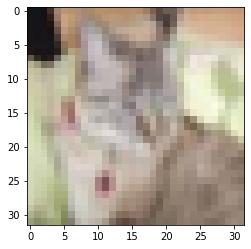

In [10]:
show_image(x, idx=idx)

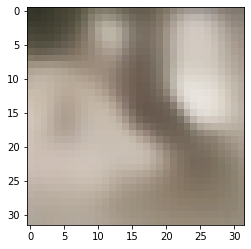

In [11]:
show_image(x_hat, idx=idx)

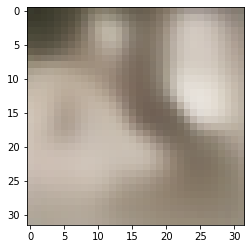

In [12]:
show_image(x_new, idx=idx)

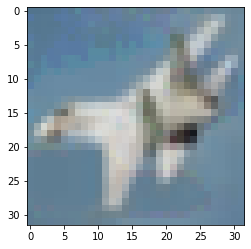

In [12]:
show_image(x_adv, idx=idx)

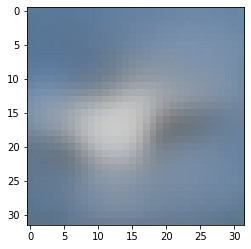

In [13]:
show_image(x_adv_new, idx=idx)